In [2]:
import sys
sys.path.append('../../code/python')
import pandas as pd
import statsmodels.api as sm
import xarray as xr
import numpy as np
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
D = pd.HDFStore('../../data/analyses/indexes.h5')

In [3]:
 def regression(field, series, intercept=True, lag=None, pval=False):
    Y = field.copy()
    if lag is not None:
        Y['time'] = Y.time + pd.Timedelta(lag)
    try:
        Y = Y.stack(space = ('lon', 'lat')).squeeze()
    except KeyError:
        Y = Y.stack(space = ('longitude', 'latitude')).squeeze()
    Y, x = xr.align(Y, xr.DataArray(series).rename({'dim_0': 'time'}))
    X = sm.tools.add_constant(x) if intercept else np.array(x, ndmin=2).T

    if pval:
        def ols(Y, X):
            res = sm.OLS(Y, X).fit()
            return res.params[1], res.pvalues[1]
        r, p = np.apply_along_axis(ols, 0, np.array(Y), X=X)
        p = xr.DataArray(p, coords=[Y.space]).unstack('space')
    else:
        r = np.linalg.lstsq(X, Y)[0][1]
    r = xr.DataArray(r, coords=[Y.space]).unstack('space')
    return (r, p) if pval else r

In [4]:
LargeMap = Basemap(
    projection = 'merc',
    llcrnrlon = -180,
    llcrnrlat = -70,
    urcrnrlon = -60,
    urcrnrlat = 10
)
SmallMap = Basemap(
    projection = 'merc',
    llcrnrlon = -85,
    llcrnrlat = -40,
    urcrnrlon = -60,
    urcrnrlat = -20,
    resolution = 'h'
)

def plot(r, p, a=None, box=None):
    plt.figure(figsize=(15,5))
    plt.set_cmap('coolwarm')
    plt.subplot(1, 2, 1)
    if a is None:
        LargeMap.pcolor(lon, lat, r.values.T, latlon=True)
    else:
        LargeMap.pcolor(lon, lat, r.values.T, latlon=True, vmin=-a[0], vmax=a[0])
    LargeMap.plot(-71.24221, -29.91502, 'bo', latlon=True, ms=10) # CEAZA
    if box is not None:
        for b in box:
            LargeMap.plot(*b, color='b', latlon=True)    
    LargeMap.drawcoastlines()
    plt.colorbar()
    LargeMap.contour(lon, lat, p.values.T, [0.05], latlon=True, colors=['w'])
    plt.subplot(1, 2, 2)
    if a is None:
        SmallMap.pcolor(lon, lat, r.values.T, latlon=True)
    else:
        SmallMap.pcolor(lon, lat, r.values.T, latlon=True, vmin=-a[1], vmax=a[1])
    SmallMap.plot(-71.24221, -29.91502, 'bo', latlon=True, ms=10) # CEAZA
    SmallMap.drawcoastlines()
    plt.colorbar()

# 2m Temperature

#### NCEP Reanalysis 2

In [3]:
with xr.open_dataset('../../data/analyses/NCEP2_T2_ppt_uv850.nc') as ds:
    T = ds['air'].load()
lon, lat = np.meshgrid(T.lon - 360, T.lat)

In [6]:
lat

array([[  8.57131004,   8.57131004,   8.57131004, ...,   8.57131004,
          8.57131004,   8.57131004],
       [  6.66657019,   6.66657019,   6.66657019, ...,   6.66657019,
          6.66657019,   6.66657019],
       [  4.76183987,   4.76183987,   4.76183987, ...,   4.76183987,
          4.76183987,   4.76183987],
       ..., 
       [-84.75319672, -84.75319672, -84.75319672, ..., -84.75319672,
        -84.75319672, -84.75319672],
       [-86.65309906, -86.65309906, -86.65309906, ..., -86.65309906,
        -86.65309906, -86.65309906],
       [-88.54199982, -88.54199982, -88.54199982, ..., -88.54199982,
        -88.54199982, -88.54199982]])

#### ERA interim

In [1]:
with xr.open_dataset('../../data/analyses/ERA-T2.nc') as ds:
    T = ds['t2m'].load()
lon, lat = np.meshgrid(T.longitude - 360, T.latitude)

NameError: name 'xr' is not defined

[pandas offset aliases](http://pandas.pydata.org/pandas-docs/stable/timeseries.html#offset-aliases)

In [9]:
Tmly = T.resample('MS', dim='time', how='mean')

In [199]:
Tdly = T.resample('D', dim='time', how='mean')

In [6]:
Tsea = T.resample('QS-Mar', dim='time', how='mean')
Tdjf = Tsea.where(T['time.month'] == 12).dropna('time')
Tdjf['time'] = Tdjf['time.year']

In [27]:
keys = ['nino34', 'nino12', 'nino4', 'nino_oni', 'nino_tni', 'aao_mly', 'sam_mly']
def reg(k):
    r, p = regression(Rmly, D[k], pval=True)
    return xr.concat((r, p), pd.Index(['slope', 'p-value'], name='variable'))

d = xr.Dataset({k: reg(k) for k in ['soi']})

In [8]:
T.time

<xarray.DataArray 'time' (time: 55520)>
array(['1979-01-01T00:00:00.000000000', '1979-01-01T06:00:00.000000000',
       '1979-01-01T12:00:00.000000000', ..., '2016-12-31T06:00:00.000000000',
       '2016-12-31T12:00:00.000000000', '2016-12-31T18:00:00.000000000'], dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 1979-01-01 1979-01-01T06:00:00 ...
Attributes:
    long_name:  time

In [28]:
d.to_netcdf('SOI_ERA_precip.nc')

## [ENSO](https://climatedataguide.ucar.edu/climate-data/nino-sst-indices-nino-12-3-34-4-oni-and-tni)

### Southern Oscillation Index (SOI)

In [14]:
r, p = regression(Tmly, D['soi_stand'], pval=True)

#### ERA

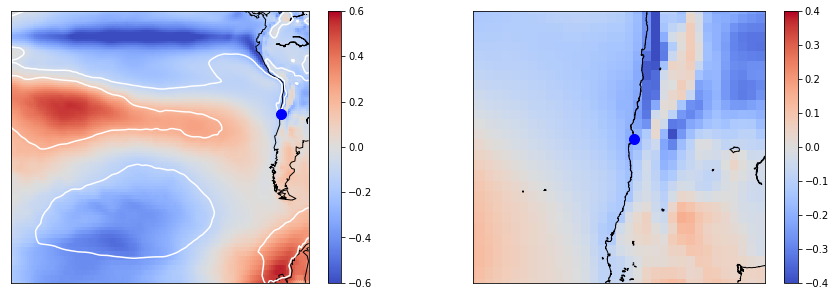

In [18]:
plot(r, p, [.6, .4])

### Niño3.4

In [178]:
r, p = regression(Tmly, D['nino34'], pval=True)
box = [([-170, -120, -120, -170, -170], [-5, -5, 5, 5, -5])]

#### NCEP

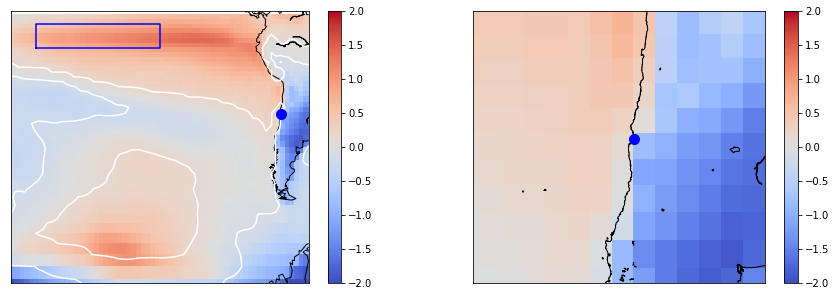

In [124]:
plot(r, p, [2, 2], box)

white lines are p-value = 0.05; blue box indicates the index region

#### ERA

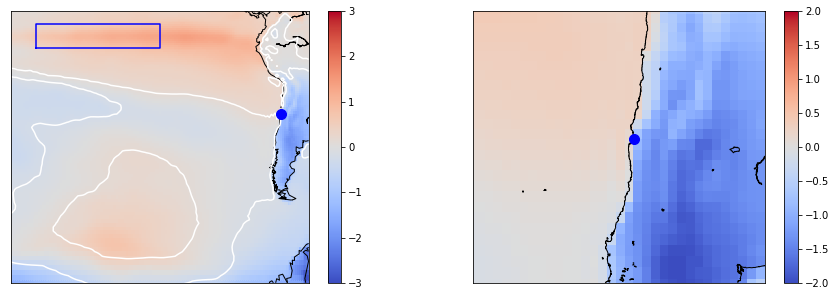

In [181]:
plot(r, p, [3, 2], box)

### Niño4

In [182]:
r, p = regression(Tmly, D['nino4'], pval=True)
box = [([-160, -150, -150, -160, -160], [-5, -5, 5, 5, -5])]

#### NCEP

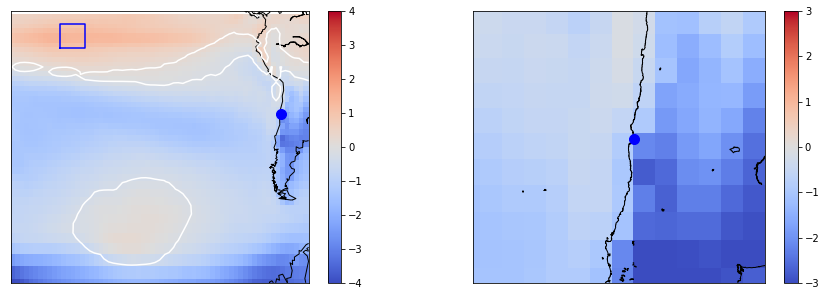

In [131]:
plot(r, p, [4, 3], box)

#### ERA

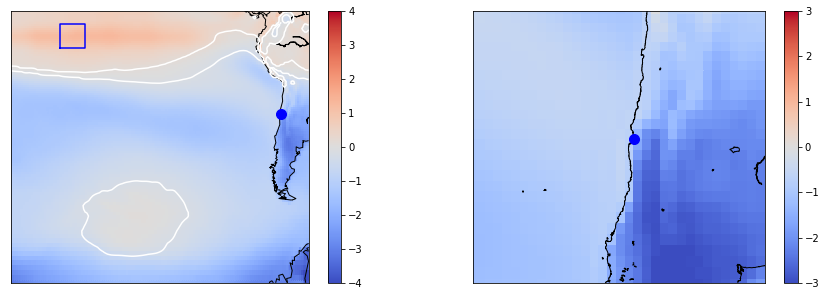

In [185]:
plot(r, p, [4, 3], box)

### Niño1+2

In [190]:
r, p = regression(Tmly, D['nino12'], pval=True)
box = [([-90, -80, -80, -90, -90], [-10, -10, 0, 0, -10])]

#### NCEP

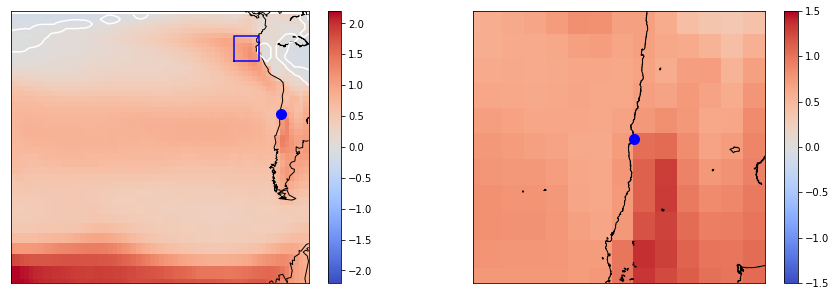

In [140]:
plot(r, p, [2.2, 1.5], box)

#### ERA

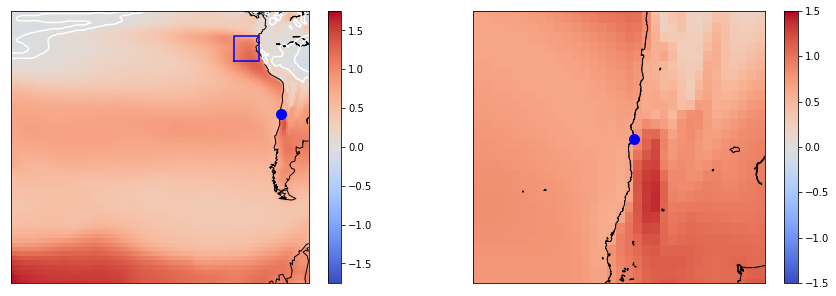

In [194]:
plot(r, p, [1.75, 1.5], box)

### Oceanic Niño Index (ONI)

In [171]:
r, p = regression(Tmly, D['nino_oni'], pval=True)
box = [([-170, -120, -120, -170, -170], [-5, -5, 5, 5, -5])]

#### NCEP

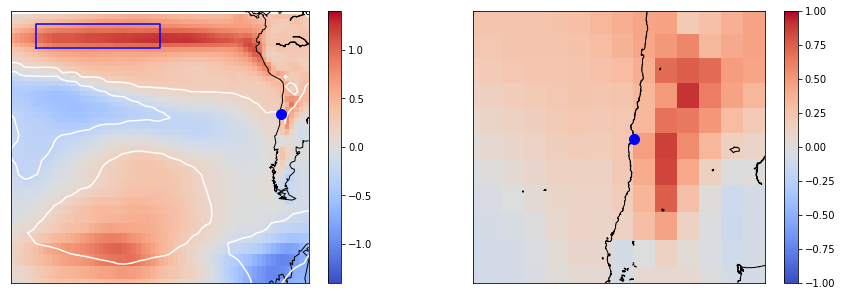

In [119]:
plot(r, p, [1.4, 1], box)

#### ERA

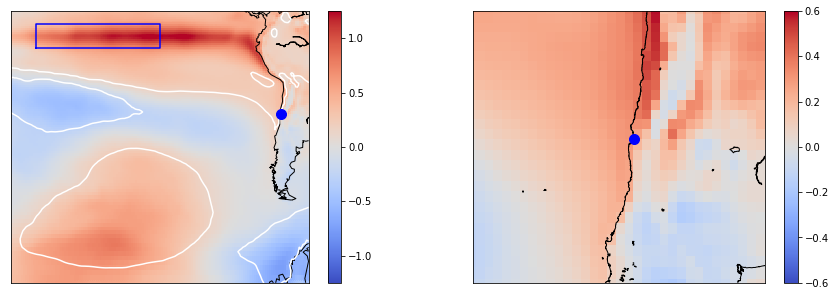

In [177]:
plot(r, p, [1.25, .6], box)

### Trans-Niño Index (TNI)

In [186]:
r, p = regression(Tmly, D['nino_tni'], pval=True)
box = [([-160, -150, -150, -160, -160], [-5, -5, 5, 5, -5]),
       ([-90, -80, -80, -90, -90], [-10, -10, 0, 0, -10])]

#### NCEP

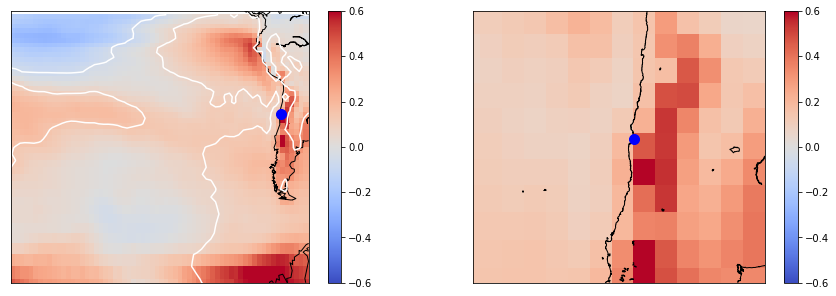

In [134]:
plot(r, p, [.6, .6])

#### ERA

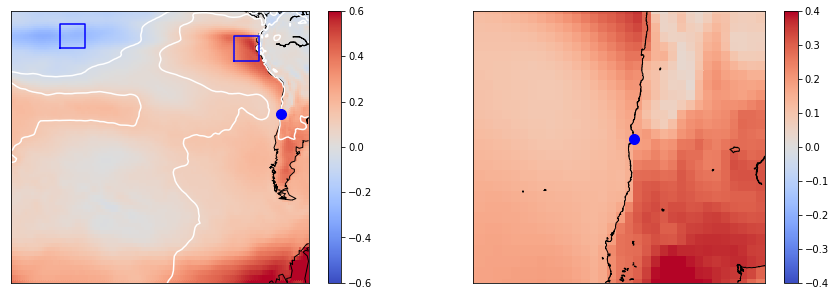

In [189]:
plot(r, p, [.6, .4], box)

## SAM

### [reanalysis-based](http://www.cpc.ncep.noaa.gov/products/precip/CWlink/daily_ao_index/aao/aao.shtml)

##### monthly

daily pretty much the same

In [195]:
r, p = regression(Tmly, D['aao_mly'], pval=True)

#### NCEP

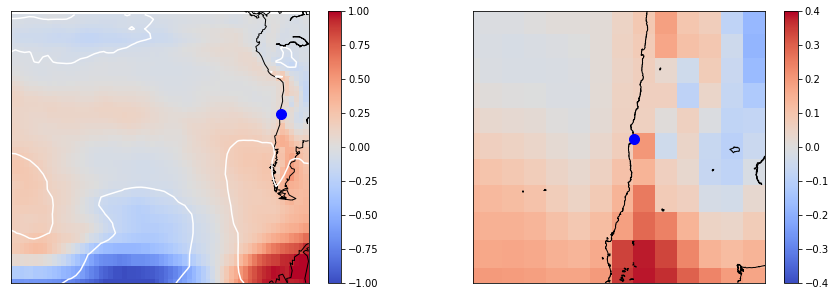

In [143]:
plot(r, p, [1, .4])

#### ERA

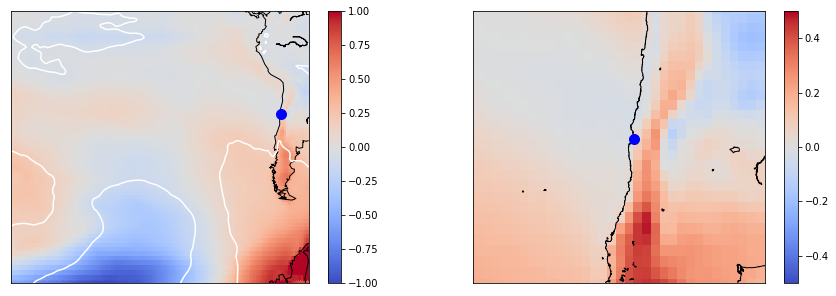

In [198]:
plot(r, p, [1, .5])

In [16]:
r, p = regression(Tdjf, aao_djf, pval=True)

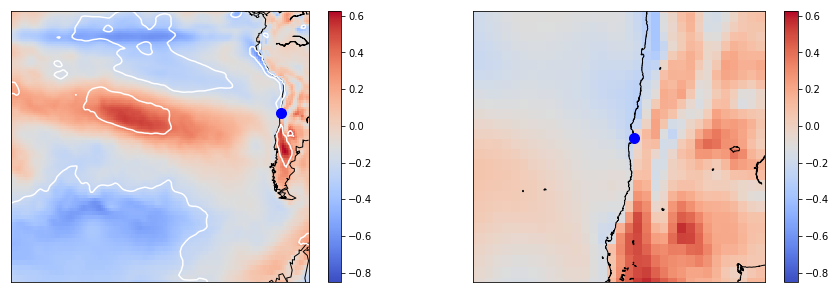

In [17]:
plot(r, p)

### [station-based (Marshall Southern Annular Mode Index)](https://climatedataguide.ucar.edu/climate-data/marshall-southern-annular-mode-sam-index-station-based)

In [202]:
r, p = regression(Tmly, D['sam_mly'], pval=True)

#### NCEP

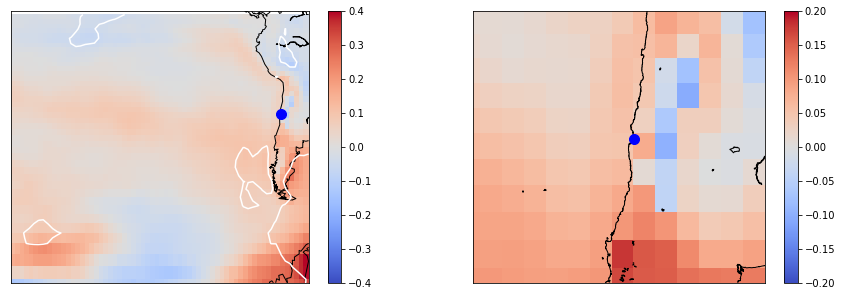

In [149]:
plot(r, p, [.4, .2])

#### ERA

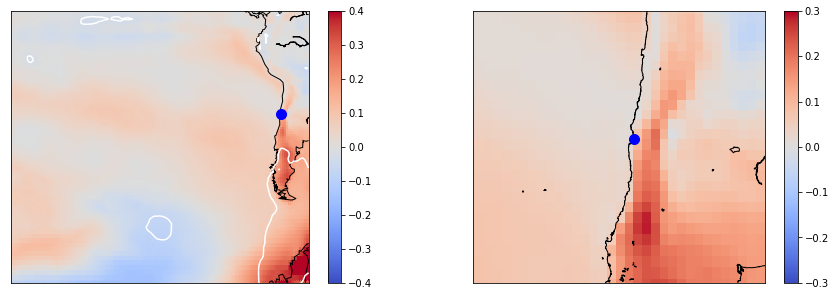

In [205]:
plot(r, p, [.4, .3])

In [8]:
r, p = regression(Tdjf, D['sam_sea']['SUM'], pval=True)

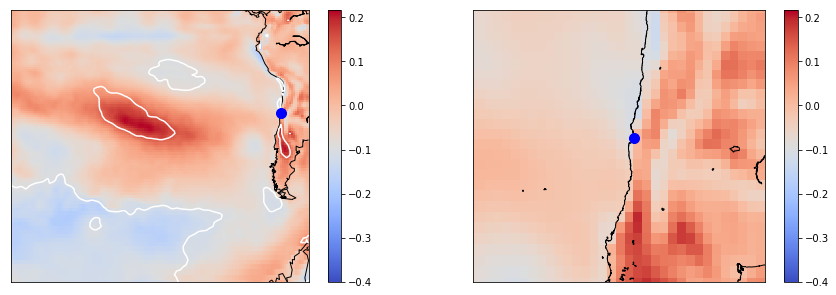

In [9]:
plot(r, p)

# Precipitation

In [34]:
with xr.open_dataset('../../data/analyses/NCEP2_T2_ppt_uv850.nc') as ds:
    rr = ds['prate'].load()
lon, lat = np.meshgrid(rr.lon - 360, rr.lat)

In [35]:
Rmly = rr.resample('MS', dim='time', how='mean') # it's a rate

In [22]:
with xr.open_dataset('../../data/analyses/ERA-ppt.nc') as ds:
    ppt = ds['tp'].load()

lon, lat = np.meshgrid(ppt.longitude - 360, ppt.latitude)
ppt['time'] = ppt.time - pd.Timedelta('1h') # to include 0:00h accumulated ppt with the previous day
Rmly = ppt.resample('MS', dim='time', how='sum')

In [49]:
Rsea = ppt.resample('QS-Mar', dim='time', how='sum')
Rdjf = Rsea.where(Rsea['time.month'] == 12).dropna('time')
Rdjf['time'] = Rdjf['time.year']

### SOI

In [23]:
r, p = regression(Rmly, D['soi_stand'], pval=True)

#### ERA

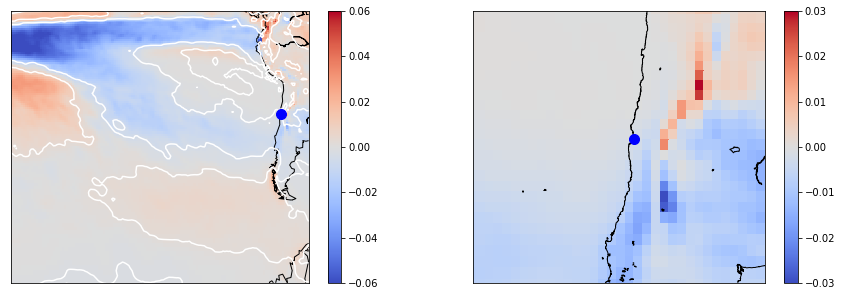

In [25]:
plot(r, p, [.06, .03])

### Niño34

#### ERA

In [62]:
r, p = regression(Rmly, D['nino34'], pval=True)
box = [([-170, -120, -120, -170, -170], [-5, -5, 5, 5, -5])]

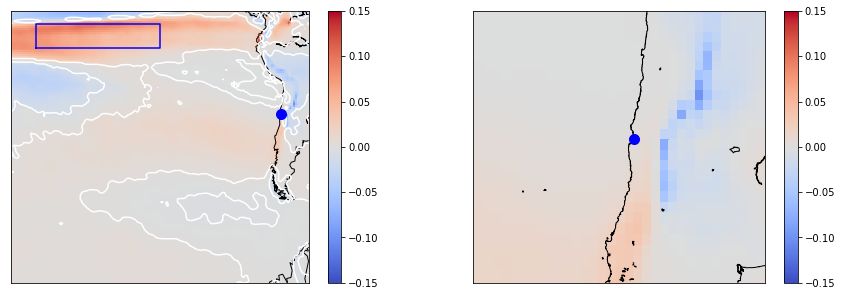

In [28]:
plot(r, p, [.15, .15], box)

#### NCEP

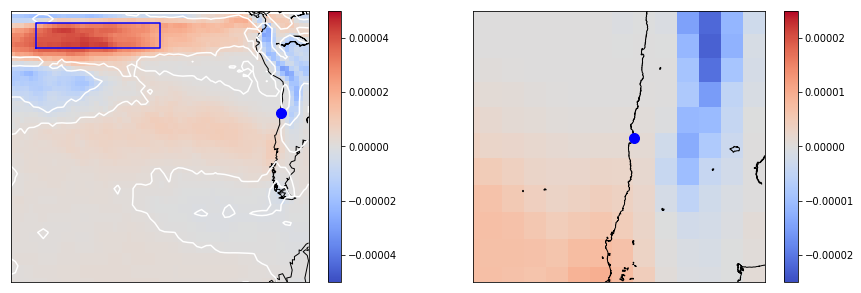

In [68]:
plot(r, p, np.array([5, 2.5])*1e-5, box)

### Niño4

In [69]:
r, p = regression(Rmly, D['nino4'], pval=True)
box = [([-160, -150, -150, -160, -160], [-5, -5, 5, 5, -5])]

#### ERA

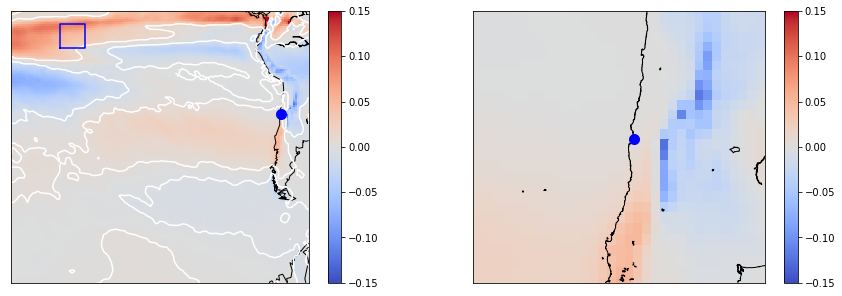

In [25]:
plot(r, p, [.15, .15], box)

#### NCEP

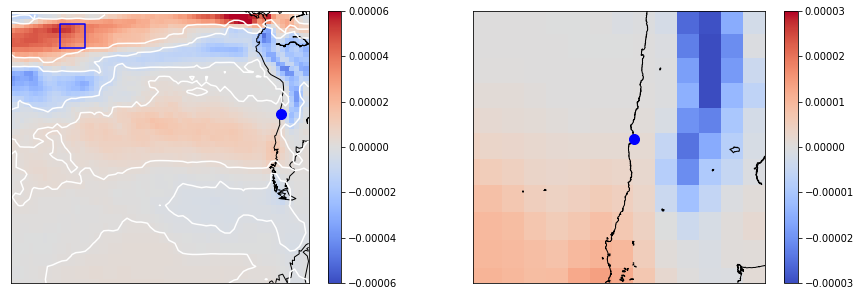

In [72]:
plot(r, p, np.array([6, 3])*1e-5, box)

### Niño1+2

In [73]:
r, p = regression(Rmly, D['nino12'], pval=True)
box = [([-90, -80, -80, -90, -90], [-10, -10, 0, 0, -10])]

#### ERA

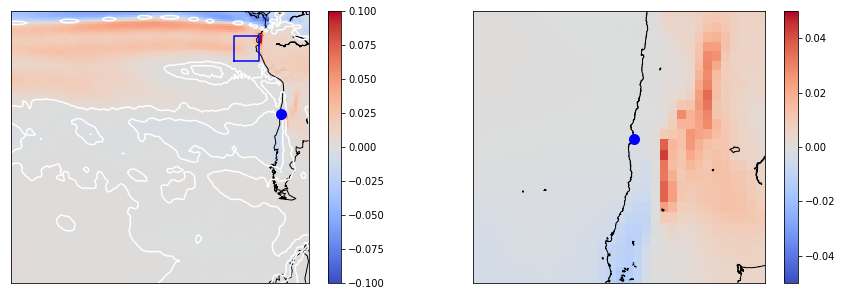

In [42]:
plot(r, p, [.1, .05], box)

#### NCEP

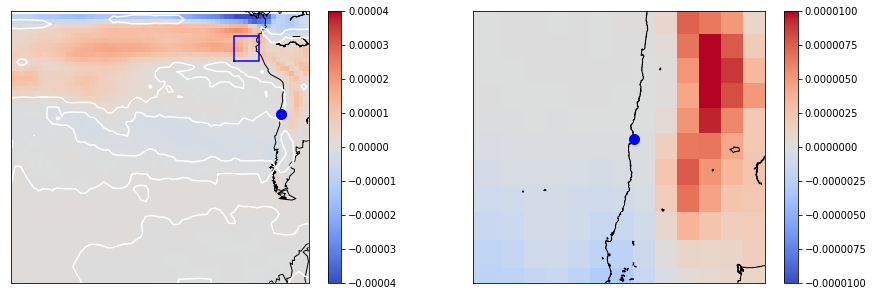

In [78]:
plot(r, p, np.array([4, 1])*1e-5, box)

### ONI

In [79]:
r, p = regression(Rmly, D['nino_oni'], pval=True)
box = [([-170, -120, -120, -170, -170], [-5, -5, 5, 5, -5])]

#### ERA

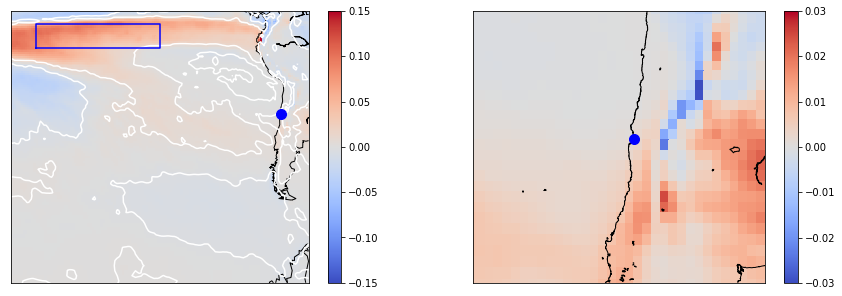

In [40]:
plot(r, p, [.15, .03], box)

#### NCEP

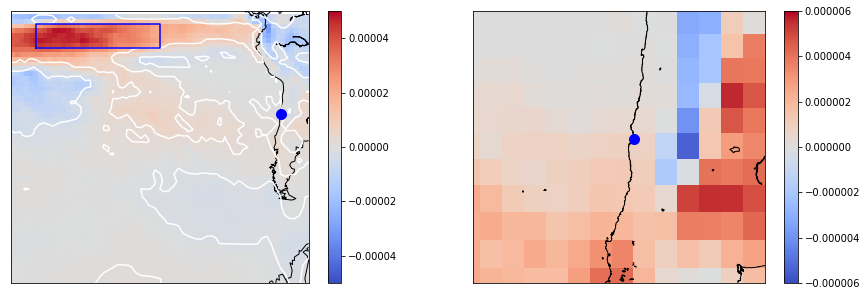

In [86]:
plot(r, p, np.array([5, .6])*1e-5, box)

### TNI

In [103]:
r, p = regression(Rmly, D['nino_tni'], pval=True)
box = [([-160, -150, -150, -160, -160], [-5, -5, 5, 5, -5]),
       ([-90, -80, -80, -90, -90], [-10, -10, 0, 0, -10])]

#### ERA

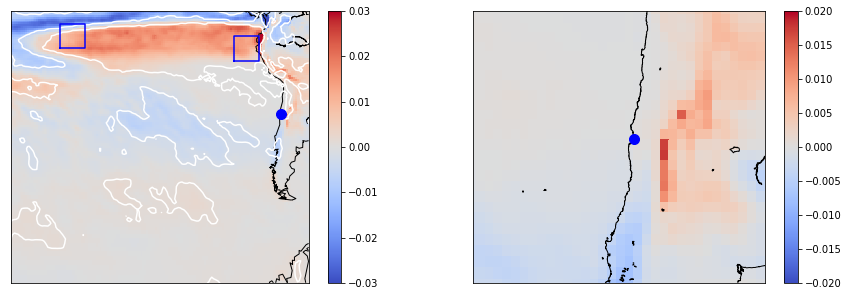

In [106]:
plot(r, p, [.03, .02], box)

#### NCEP

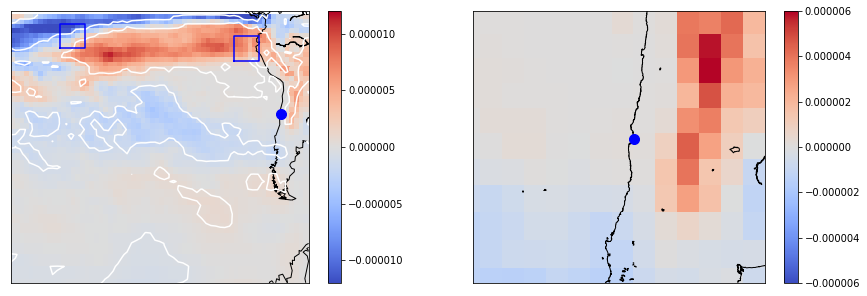

In [93]:
plot(r, p, np.array([1.2, .6])*1e-5, box)

## SAM

### reanalysis

In [10]:
aao_djf = D['aao_mly'].resample('QS-Mar').mean()
aao_djf = aao_djf[aao_djf.index.month==12]
aao_djf.index = aao_djf.index.year

In [81]:
r, p = regression(Rdjf, aao_djf, pval=True)

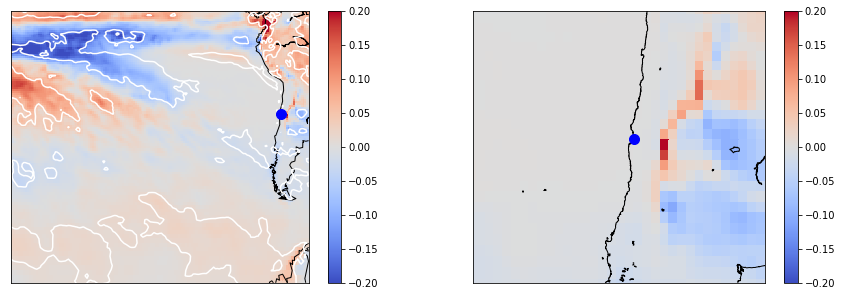

In [86]:
plot(r, p, [.2, .2])

In [94]:
r, p = regression(Rmly, D['aao_mly'], pval=True)

#### ERA

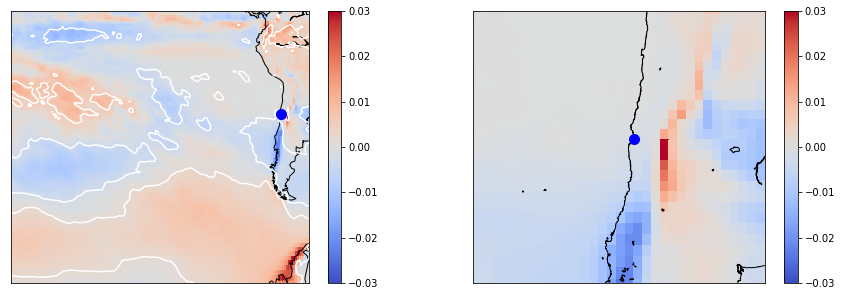

In [52]:
plot(r, p, [.03, .03])

#### NCEP

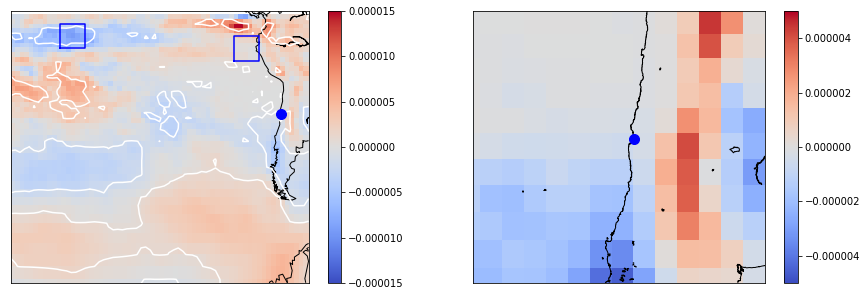

In [96]:
plot(r, p, np.array([1.5, .5])*1e-5, box)

### Marshall

In [97]:
r, p = regression(Rmly, D['sam_mly'], pval=True)

#### ERA

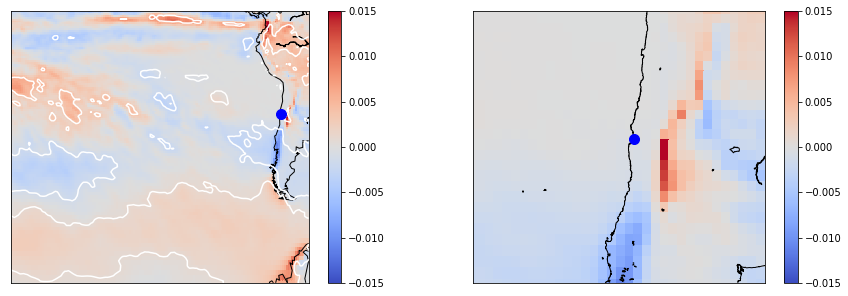

In [58]:
plot(r, p, [.015, .015])

In [89]:
r, p = regression(Rdjf, D['sam_sea']['SUM'], pval=True)

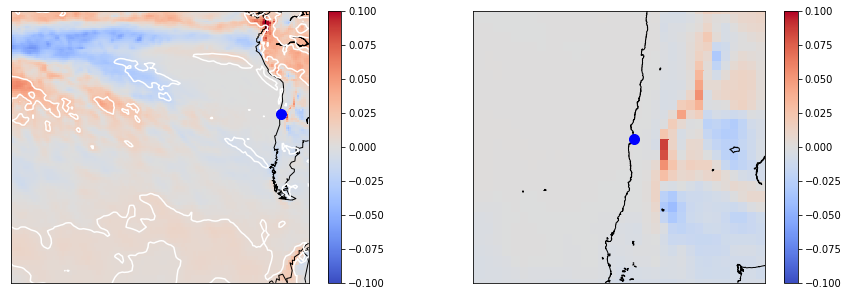

In [61]:
plot(r, p, [.1, .1])

#### NCEP

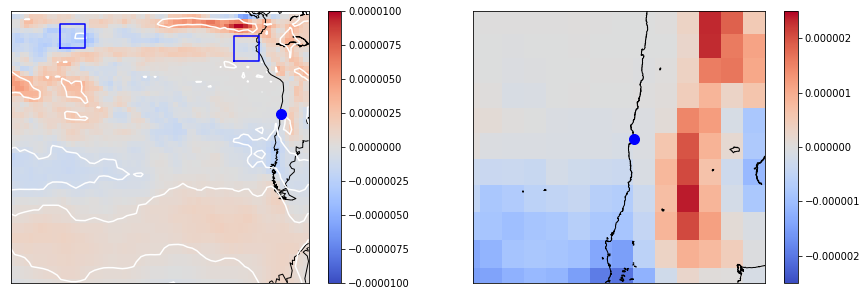

In [101]:
plot(r, p, np.array([1, .25])*1e-5)

# precipiation against wind

In [ ]:
with xr.open_dataset('../../data/analyses/ERA-ws.nc') as ds:
    ws = ds['ws'].load()
lon, lat = np.meshgrid(ws.lon - 360, ws.lat)

In [ ]:
wmly = ws.resample('MS', dim='time', how='mean')

In [6]:
wdly = ws.resample('D', dim='time', how='mean')
Rdly = ppt.resample('D', dim='time', how='mean')

In [10]:
def regression(x, y):
    X = xr.concat((x, y), pd.Index(['X', 'Y'], name='var'))
    X = X.stack(space = ('longitude', 'latitude'))
    X = X.stack(col = ('time', 'var'))
    def ols(X):
        res = sm.OLS(X[1::2], sm.tools.add_constant(X[::2])).fit()
        return res.params[1], res.pvalues[1]
    r, p = np.apply_along_axis(ols, 1, X).T
    return [xr.DataArray(x, coords=[X.space]).unstack('space') for x in [r, p]]

In [135]:
r, p = regression(wmly, Rmly)

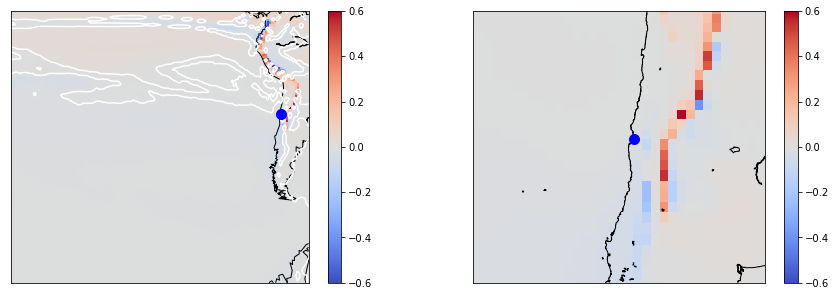

In [136]:
plot(-r, p, [.6, .6])